In [3]:
from netCDF4 import Dataset
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature, COLORS
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

from wrf import (getvar, interplevel, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim, vertcross, smooth2d, CoordPair, 
                 GeoBounds, interpline, CoordPair,ll_to_xy)


In [22]:
# Open the NetCDF file
path = "~/wrf/conus_12km/"
wrf_output_dir = os.path.expanduser(path)
ncfile = Dataset(wrf_output_dir+"wrfout_d01_2019-11-27_00:00:00")

"""Output Files from conus_12km experiment
wrfout_d01_2019-11-26_12:00:00
wrfout_d01_2019-11-26_13:00:00
wrfout_d01_2019-11-26_14:00:00
wrfout_d01_2019-11-26_15:00:00
wrfout_d01_2019-11-26_16:00:00
wrfout_d01_2019-11-26_17:00:00
wrfout_d01_2019-11-26_18:00:00
wrfout_d01_2019-11-26_19:00:00
wrfout_d01_2019-11-26_20:00:00
wrfout_d01_2019-11-26_21:00:00
wrfout_d01_2019-11-26_22:00:00
wrfout_d01_2019-11-26_23:00:00
wrfout_d01_2019-11-27_00:00:00
"""

'Output Files from conus_12km experiment\nwrfout_d01_2019-11-26_12:00:00\nwrfout_d01_2019-11-26_13:00:00\nwrfout_d01_2019-11-26_14:00:00\nwrfout_d01_2019-11-26_15:00:00\nwrfout_d01_2019-11-26_16:00:00\nwrfout_d01_2019-11-26_17:00:00\nwrfout_d01_2019-11-26_18:00:00\nwrfout_d01_2019-11-26_19:00:00\nwrfout_d01_2019-11-26_20:00:00\nwrfout_d01_2019-11-26_21:00:00\nwrfout_d01_2019-11-26_22:00:00\nwrfout_d01_2019-11-26_23:00:00\nwrfout_d01_2019-11-27_00:00:00\n'

**Plot Horizontal Interpolation to a Pressure Level**

In [14]:
def plot_horizontal_pressure_level():
    # Extract the pressure, geopotential height, and wind variables
    p = getvar(ncfile, "pressure")
    z = getvar(ncfile, "z", units="dm")
    ua = getvar(ncfile, "ua", units="kt")
    va = getvar(ncfile, "va", units="kt")
    wspd = getvar(ncfile, "wspd_wdir", units="kts")[0,:]

    # Interpolate geopotential height, u, and v winds to 500 hPa
    ht_500 = interplevel(z, p, 500)
    u_500 = interplevel(ua, p, 500)
    v_500 = interplevel(va, p, 500)
    wspd_500 = interplevel(wspd, p, 500)

    # Get the lat/lon coordinates
    lats, lons = latlon_coords(ht_500)

    # Get the map projection information
    cart_proj = get_cartopy(ht_500)

    # Create the figure
    fig = plt.figure(figsize=(12,9))
    ax = plt.axes(projection=cart_proj)

    # Download and add the states and coastlines
    states = NaturalEarthFeature(category="cultural", scale="50m",
                                 facecolor="none",
                                 name="admin_1_states_provinces")
    ax.add_feature(states, linewidth=0.5, edgecolor="black")
    ax.coastlines('50m', linewidth=0.8)

    # Add the 500 hPa geopotential height contours
    levels = np.arange(520., 580., 6.)
    contours = plt.contour(to_np(lons), to_np(lats), to_np(ht_500),
                           levels=levels, colors="black",
                           transform=crs.PlateCarree())
    plt.clabel(contours, inline=1, fontsize=10, fmt="%i")

    # Add the wind speed contours
    levels = [25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120]
    wspd_contours = plt.contourf(to_np(lons), to_np(lats), to_np(wspd_500),
                                 levels=levels,
                                 cmap=matplotlib.colormaps["rainbow"],
                                 transform=crs.PlateCarree())
    plt.colorbar(wspd_contours, ax=ax, orientation="horizontal", pad=.05)

    # Add the 500 hPa wind barbs, only plotting every 125th data point.
    plt.barbs(to_np(lons[::125,::125]), to_np(lats[::125,::125]),
              to_np(u_500[::125, ::125]), to_np(v_500[::125, ::125]),
              transform=crs.PlateCarree(), length=6)

    # Set the map bounds
    ax.set_xlim(cartopy_xlim(ht_500))
    ax.set_ylim(cartopy_ylim(ht_500))

    ax.gridlines()

    plt.title("500 MB Height (dm), Wind Speed (kt), Barbs (kt)")

    plt.show()


**Plot Cross Section with Mountains**

In [15]:
def plot_mountain_cross_section():
    # Define the cross section start and end points
    cross_start = CoordPair(lat=38.0, lon=-125.0)
    cross_end = CoordPair(lat=38.0, lon=-75.0)

    # Get the WRF variables
    ht = getvar(ncfile, "z", timeidx=-1)
    ter = getvar(ncfile, "ter", timeidx=-1)
    dbz = getvar(ncfile, "dbz", timeidx=-1)
    max_dbz = getvar(ncfile, "mdbz", timeidx=-1)
    Z = 10**(dbz/10.) # Use linear Z for interpolation

    # Compute the vertical cross-section interpolation.  Also, include the
    # lat/lon points along the cross-section in the metadata by setting latlon
    # to True.
    z_cross = vertcross(Z, ht, wrfin=ncfile,
                        start_point=cross_start,
                        end_point=cross_end,
                        latlon=True, meta=True)

    # Convert back to dBz after interpolation
    dbz_cross = 10.0 * np.log10(z_cross)

    # Add back the attributes that xarray dropped from the operations above
    dbz_cross.attrs.update(z_cross.attrs)
    dbz_cross.attrs["description"] = "radar reflectivity cross section"
    dbz_cross.attrs["units"] = "dBZ"

    # To remove the slight gap between the dbz contours and terrain due to the
    # contouring of gridded data, a new vertical grid spacing, and model grid
    # staggering, fill in the lower grid cells with the first non-missing value
    # for each column.

    # Make a copy of the z cross data. Let's use regular numpy arrays for this.
    dbz_cross_filled = np.ma.copy(to_np(dbz_cross))

    # For each cross section column, find the first index with non-missing
    # values and copy these to the missing elements below.
    for i in range(dbz_cross_filled.shape[-1]):
        column_vals = dbz_cross_filled[:,i]
        # Let's find the lowest index that isn't filled. The nonzero function
        # finds all unmasked values greater than 0. Since 0 is a valid value
        # for dBZ, let's change that threshold to be -200 dBZ instead.
        first_idx = int(np.transpose((column_vals > -200).nonzero())[0])
        dbz_cross_filled[0:first_idx, i] = dbz_cross_filled[first_idx, i]
        
    # Get the terrain heights along the cross section line
    ter_line = interpline(ter, wrfin=ncfile, start_point=cross_start,
                          end_point=cross_end)

    # Get the lat/lon points
    lats, lons = latlon_coords(dbz)

    # Get the cartopy projection object
    cart_proj = get_cartopy(dbz)

    # Create the figure
    fig = plt.figure(figsize=(10,7))
    ax_cross = plt.axes()

    dbz_levels = np.arange(5., 75., 5.)

    # Create the color table found on NWS pages.
    dbz_rgb = np.array([[4,233,231],
                        [1,159,244], [3,0,244],
                        [2,253,2], [1,197,1],
                        [0,142,0], [253,248,2],
                        [229,188,0], [253,149,0],
                        [253,0,0], [212,0,0],
                        [188,0,0],[248,0,253],
                        [152,84,198]], np.float32) / 255.0

    dbz_map, dbz_norm = from_levels_and_colors(dbz_levels, dbz_rgb,
                                               extend="max")

    # Make the cross section plot for dbz
    dbz_levels = np.arange(5.,75.,5.)
    xs = np.arange(0, dbz_cross.shape[-1], 1)
    ys = to_np(dbz_cross.coords["vertical"])
    dbz_contours = ax_cross.contourf(xs,
                                     ys,
                                     to_np(dbz_cross_filled),
                                     levels=dbz_levels,
                                     cmap=dbz_map,
                                     norm=dbz_norm,
                                     extend="max")
    # Add the color bar
    cb_dbz = fig.colorbar(dbz_contours, ax=ax_cross)
    cb_dbz.ax.tick_params(labelsize=8)

    # Fill in the mountain area
    ht_fill = ax_cross.fill_between(xs, 0, to_np(ter_line),
                                    facecolor="saddlebrown")

    # Set the x-ticks to use latitude and longitude labels
    coord_pairs = to_np(dbz_cross.coords["xy_loc"])
    x_ticks = np.arange(coord_pairs.shape[0])
    x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]

    # Set the desired number of x ticks below
    num_ticks = 5
    thin = int((len(x_ticks) / num_ticks) + .5)
    ax_cross.set_xticks(x_ticks[::thin])
    ax_cross.set_xticklabels(x_labels[::thin], rotation=45, fontsize=8)

    # Set the x-axis and  y-axis labels
    ax_cross.set_xlabel("Latitude, Longitude", fontsize=12)
    ax_cross.set_ylabel("Height (m)", fontsize=12)

    # Add a title
    ax_cross.set_title("Cross-Section of Reflectivity (dBZ)", {"fontsize" : 14})

    plt.show()

In [16]:
def plot_sea_level_pressure():
    slp = getvar(ncfile, "slp")
    smooth_slp = smooth2d(slp, 3)
    lats, lons = latlon_coords(slp)

    cart_proj = get_cartopy(slp)

    fig = plt.figure(figsize=(15,15))
    ax = plt.axes(projection=cart_proj)

    states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                                 name='admin_1_states_provinces')
    ax.add_feature(states, linewidth=.5)
    ax.coastlines('50m', linewidth=0.8)

    # Add a title
    ax.set_title("Sea Level Pressure", {"fontsize" : 14})

    # Can only get this to work if I manually transform the lat/lon points to projected space.
    xform_coords = cart_proj.transform_points(crs.PlateCarree(), to_np(lons), to_np(lats))
    x = xform_coords[:,:,0]
    y = xform_coords[:,:,1]

    plt.contour(x, y, to_np(smooth_slp), 10, colors="black")
    plt.contourf(x, y, to_np(smooth_slp), 10)
    plt.colorbar(ax=ax, shrink=.47)

    ax.set_xlim(cartopy_xlim(slp))
    ax.set_ylim(cartopy_ylim(slp))
    ax.gridlines()

In [17]:
def plot_heights_and_winds():
    # Get the sea level pressure
    slp = getvar(ncfile, "slp")
    p = getvar(ncfile, "pressure")
    z = getvar(ncfile, "z", units="dm")
    ua = getvar(ncfile, "ua", units="kts")
    va = getvar(ncfile, "va", units="kts")

    ht_500 = interplevel(z, p, 500)
    u_500 = interplevel(ua, p, 500)
    v_500 = interplevel(va, p, 500)

    lats, lons = latlon_coords(ht_500)

    cart_proj = get_cartopy(slp)

    fig = plt.figure(figsize=(20,20))
    ax = plt.axes([0.1,0.1,0.8,0.8], projection=cart_proj)

    states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                                 name='admin_1_states_provinces')
    ax.add_feature(states, linewidth=0.5)
    ax.coastlines('50m', linewidth=0.8)
    
    # Add a title
    ax.set_title("500 mb heights and winds", {"fontsize" : 14})

    # Can only get this to work if I manually transform the lat/lon points to projected space.
    xform_coords = cart_proj.transform_points(crs.PlateCarree(), to_np(lons), to_np(lats))
    x = xform_coords[:,:,0]
    y = xform_coords[:,:,1]

    plt.contour(x, y, to_np(ht_500), 20, cmap=matplotlib.colormaps["plasma"])
    plt.barbs(x[::50,::50], y[::50,::50], to_np(u_500[::50, ::50]), to_np(v_500[::50, ::50]))
    plt.colorbar(ax=ax, shrink=.7)

    ax.set_xlim(cartopy_xlim(slp))
    ax.set_ylim(cartopy_ylim(slp))
    ax.gridlines()

In [18]:
def plot_skewt(lat, lon):

    p = getvar(ncfile, "p", units="hPa")
    z = getvar(ncfile, "z", units="m")
    t = getvar(ncfile, "tc")
    td = getvar(ncfile, "td", units="degC")
    u = getvar(ncfile, "uvmet", units="kt")[0,:]
    v = getvar(ncfile, "uvmet", units="kt")[1,:]
    xloc, yloc = to_np(ll_to_xy(ncfile, lat, lon))

    p = p.sel(south_north=yloc, west_east=xloc)
    z = z.sel(south_north=yloc, west_east=xloc)
    t = t.sel(south_north=yloc, west_east=xloc)
    td = td.sel(south_north=yloc, west_east=xloc)
    u = u.sel(south_north=yloc, west_east=xloc)
    v = v.sel(south_north=yloc, west_east=xloc)

    # Create a figure instance, 12" x 9" at 300 dots per inch.
    fig = plt.figure(figsize=(12, 9), dpi=300.)

    # Ascribe the figure instance to a metpy SkewT object.
    skew = SkewT(fig)

    # Set the sounding's axis parameters: in this case, -60 to +40 C
    # for the skewed x axis and 1000-100 hPa for the logarithmic y axis.
    # We also specify to place tick marks and labels on both axes.
    skew.ax.set_xlim(-60.,40.)
    skew.ax.set_ylim(1000.,100.)
    skew.ax.tick_params(axis='both',labelsize=14)

    # Plot our fields: temperature, then dewpoint, then winds.
    # After doing so, we add a standard set of lines to the
    # plot: dry adiabats, moist adiabats (or pseudoadiabats),
    # and mixing-ratio lines. Finally, we label the axes and
    # give the plot a title.
    skew.plot(p,t,'r',linewidth=4)
    skew.plot(p,td,'g',linewidth=4)
    skew.plot_barbs(p,u,v)
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()
    skew.ax.set_xlabel("Temperature (°C)", fontsize=16, weight='bold')
    skew.ax.set_ylabel("Pressure (hPa)", fontsize=16, weight='bold')
    skew.ax.set_title('Model Sounding at (' + str(lat) + ', ' + str(lon), 
                      fontsize=16, weight='bold')

    # Show the image.
    plt.show()

**Plotting using NCAR's wrf-python**
Documentation can be found at https://wrf-python.readthedocs.io/en/latest/index.html

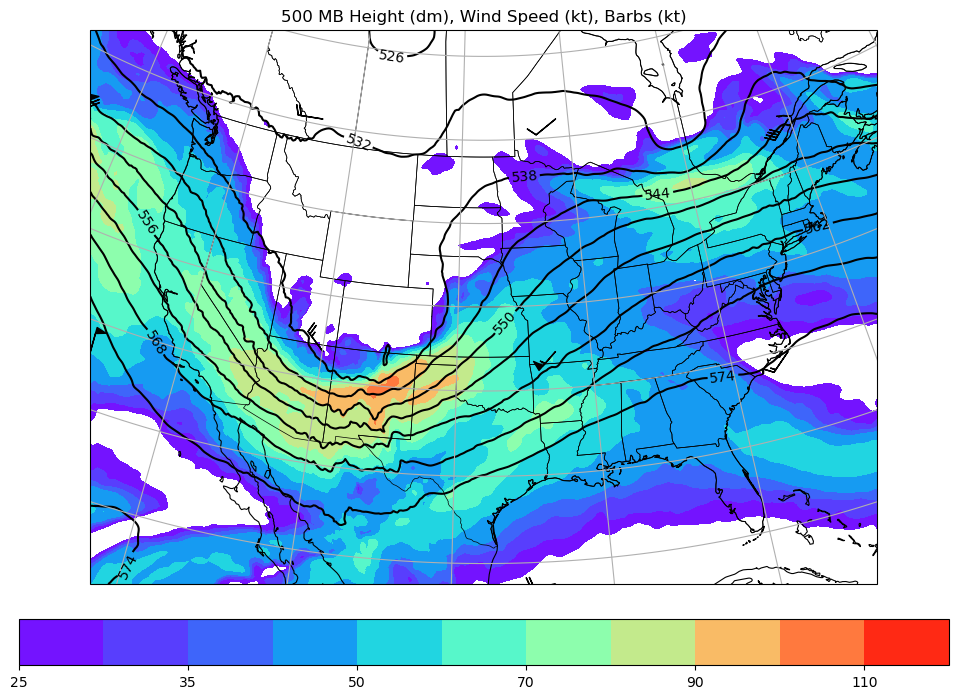

/tmp/ipykernel_19161/783110408.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  first_idx = int(np.transpose((column_vals > -200).nonzero())[0])


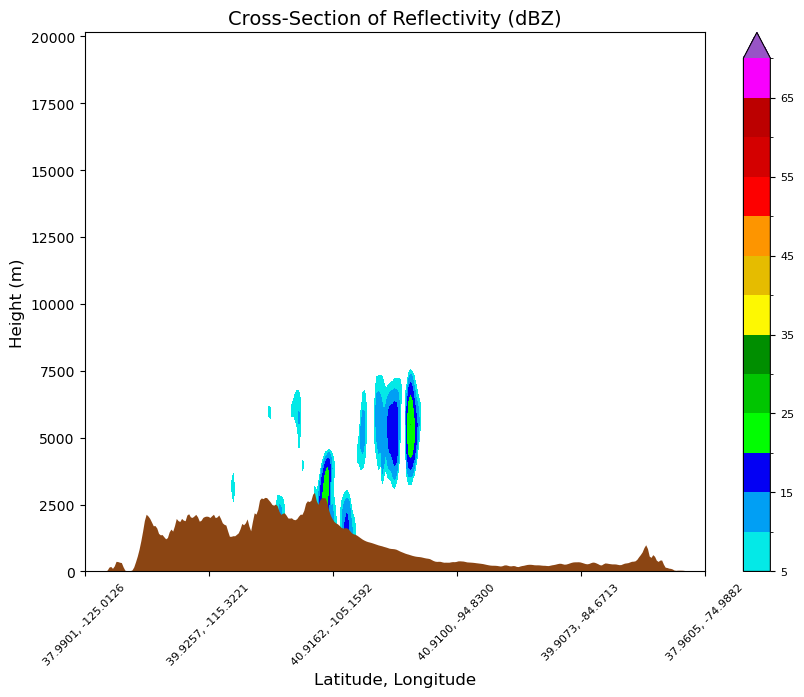

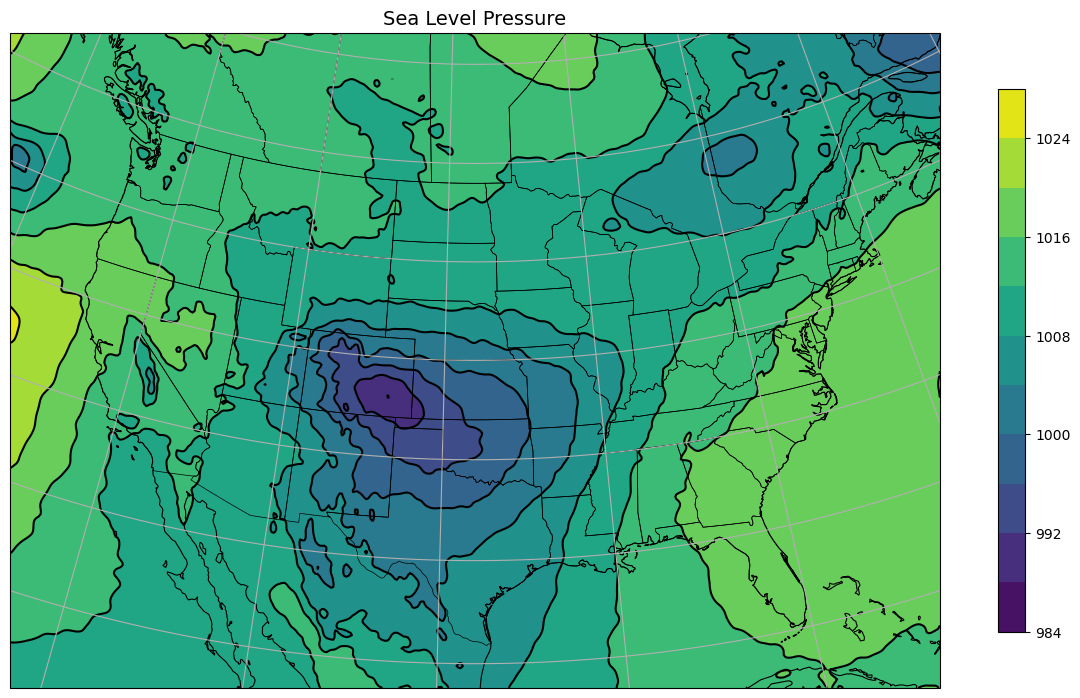

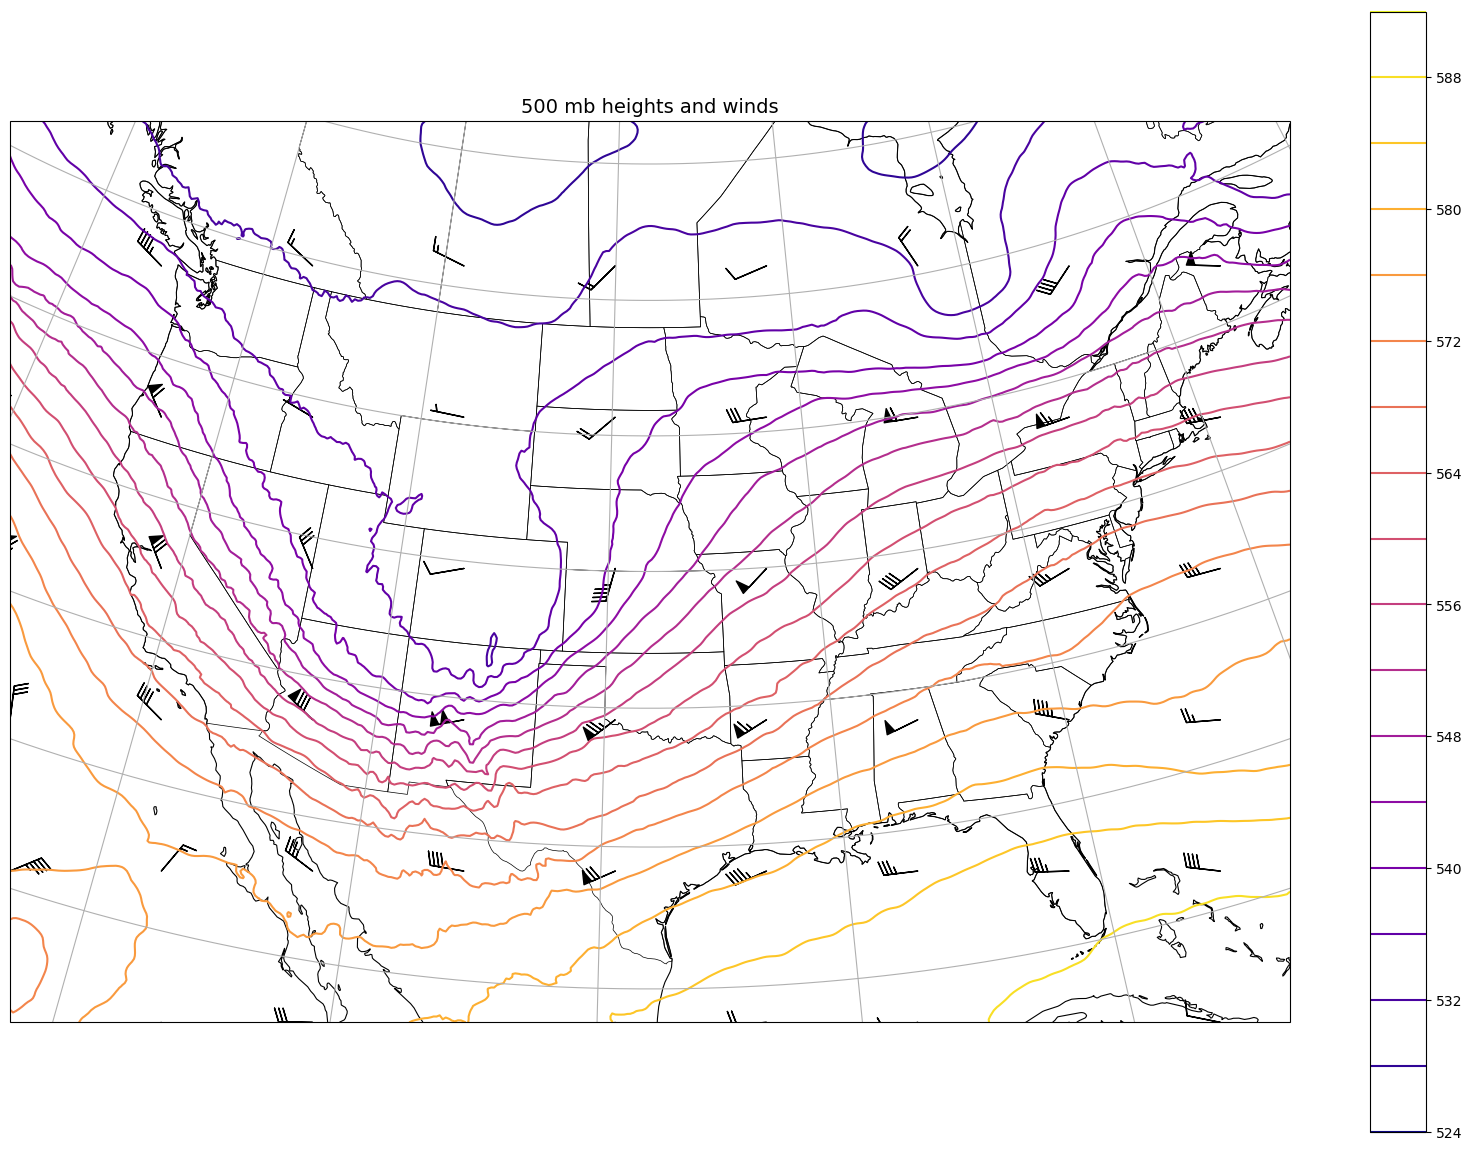

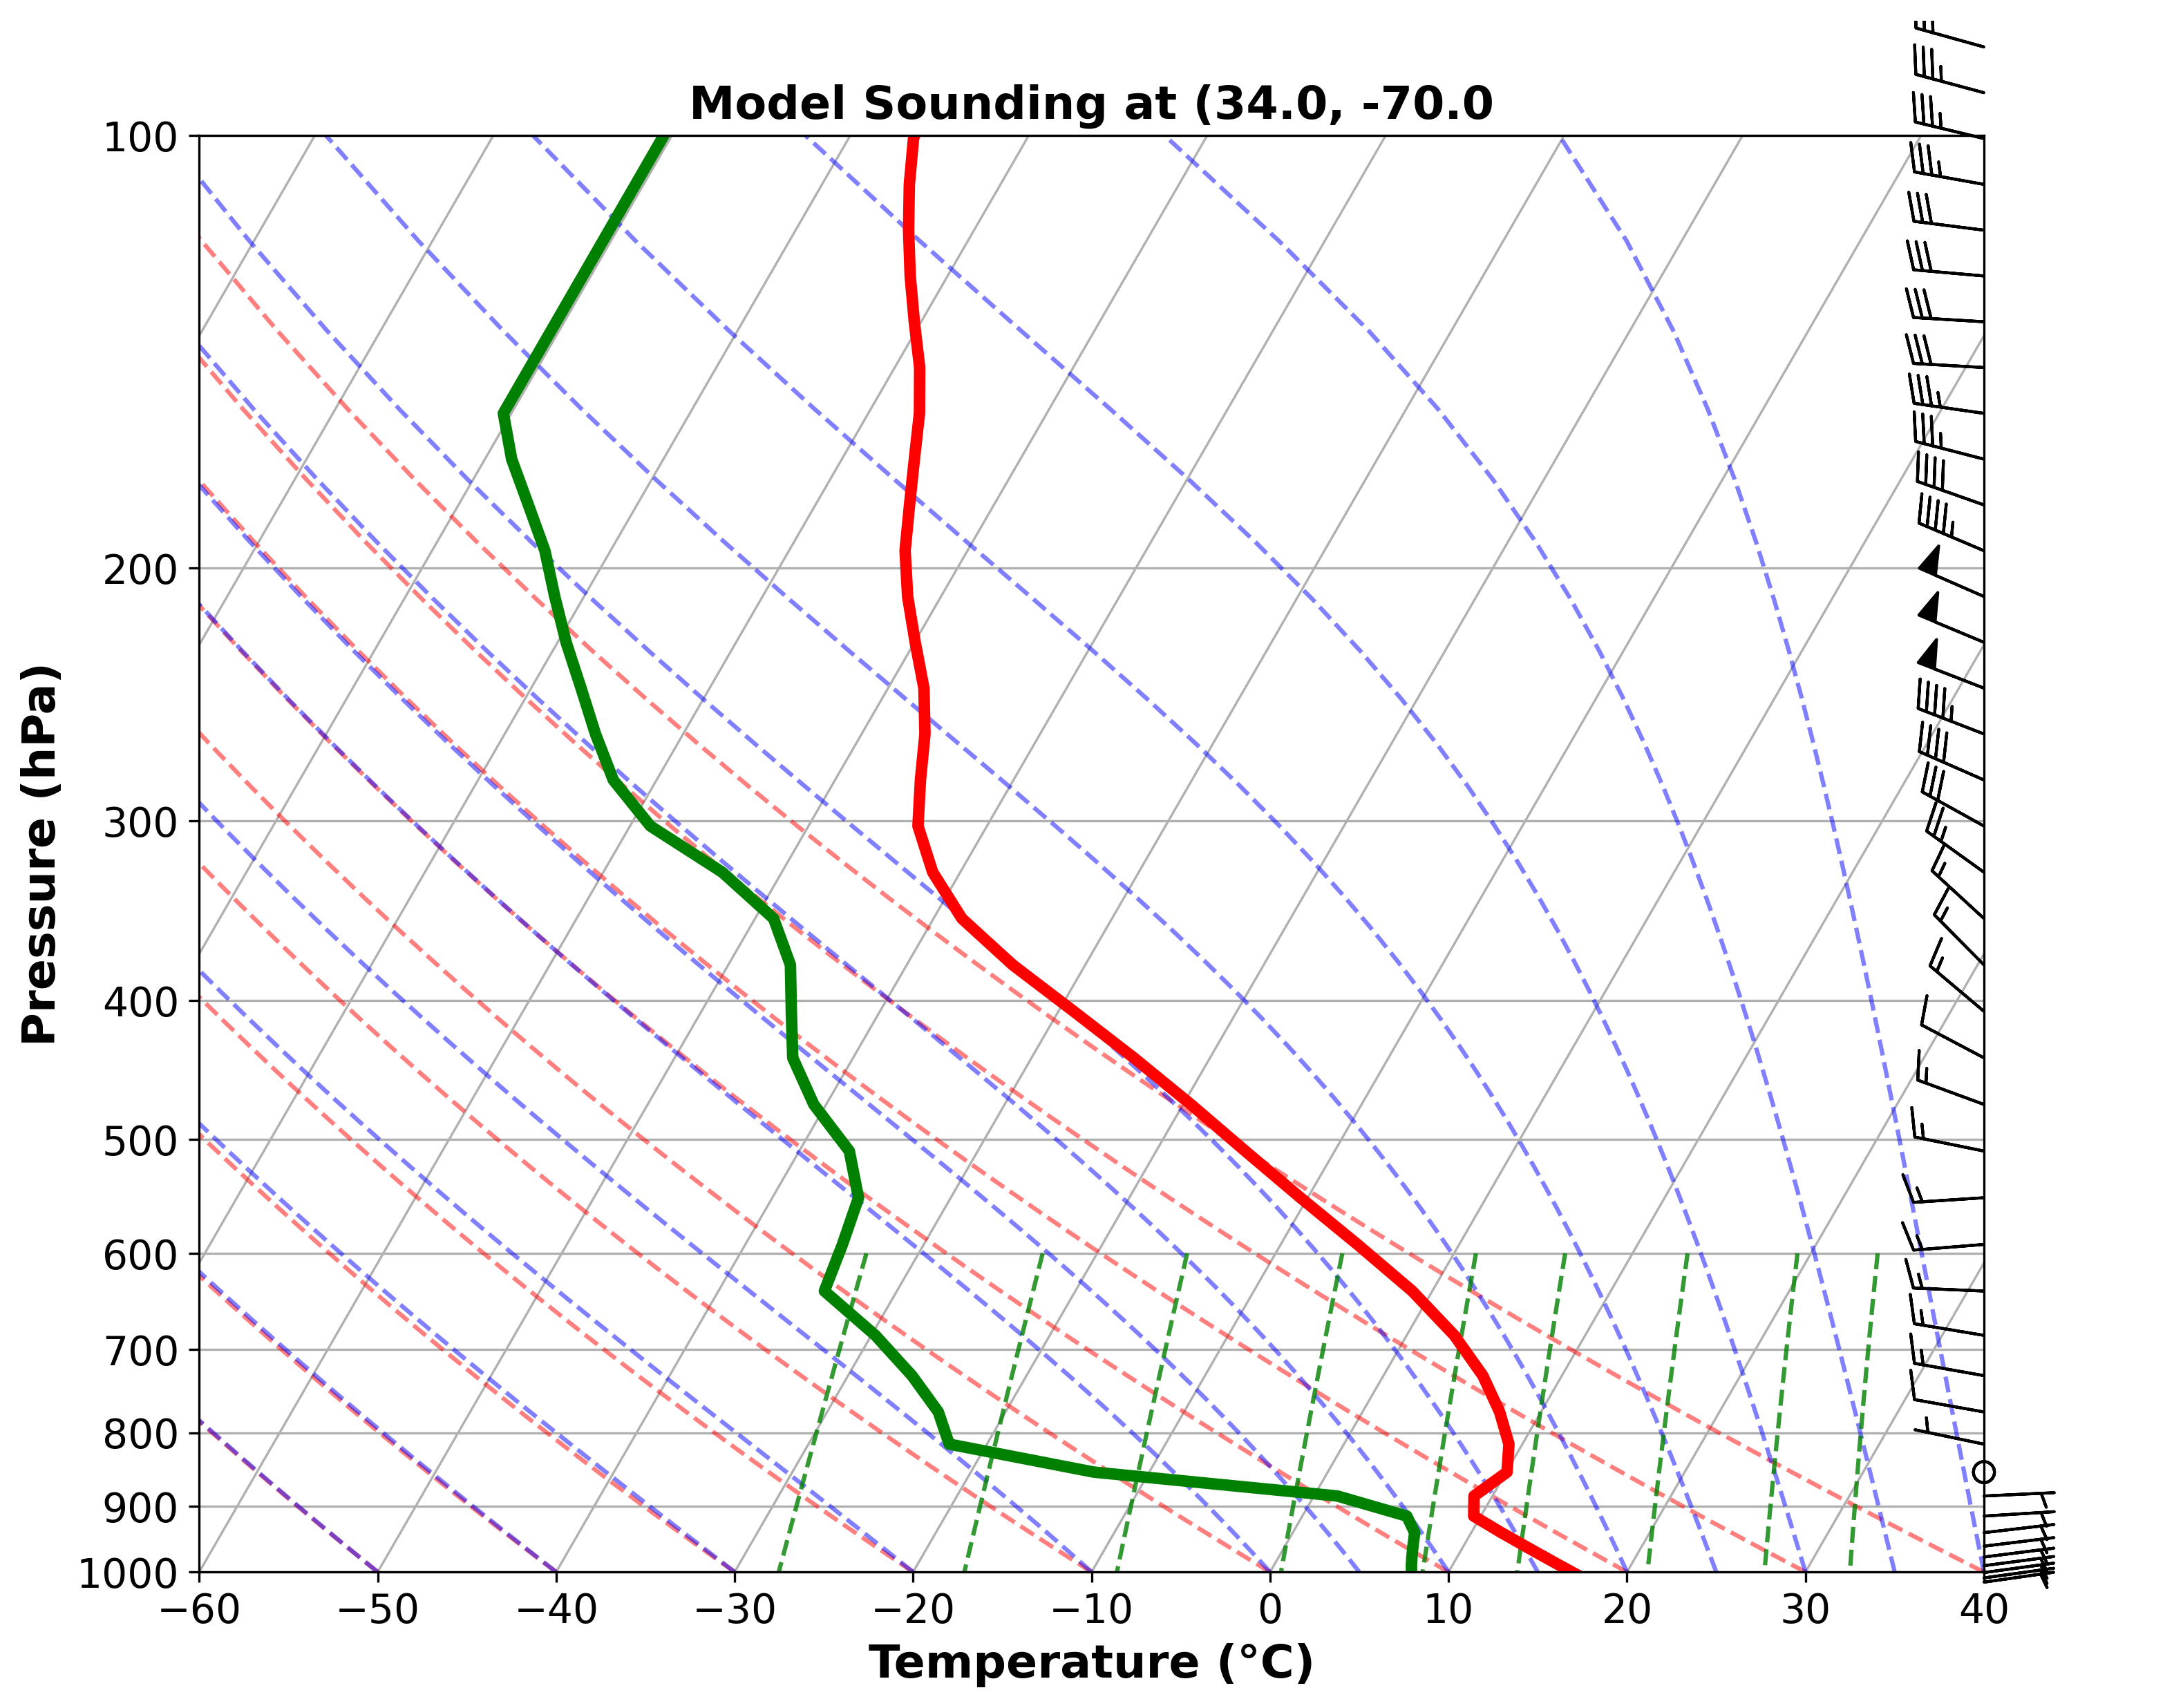

In [21]:
#Uncomment one or more desired plot types:

plot_horizontal_pressure_level()
plot_mountain_cross_section()
plot_sea_level_pressure()
plot_heights_and_winds()
plot_skewt(34.0,-70.0)